In [2]:
from numerapi import NumerAPI, utils
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

napi = NumerAPI()

In [5]:
query = '''query simpleRoundsRequest($my_round: Int!) {
  RoundDetails(roundNumber: $my_round, tournament:11) {
    roundNumber,
    totalAtStake,
    totalPayout,
    totalStakes,
    status,
    payoutFactor,
    openTime,
    models {
      modelName,
      selectedStakeValue,
    }    
  }
}'''

allRounds = []
stakedThreshold = 1
print('Loading data...')

for my_round in range(235, napi.get_current_round()):
    args = {'my_round':my_round}
    data = napi.raw_query(query, args)['data']['RoundDetails']
    
    staked_models = pd.DataFrame(data['models'])
    staked_models.selectedStakeValue = staked_models.selectedStakeValue.astype(float)
    staked_model_count = len(staked_models[staked_models.selectedStakeValue > stakedThreshold])
    data.update({'staked_model_count':staked_model_count})
    
    allRounds.append(data)

results = pd.DataFrame(allRounds)
modelNames = staked_models.modelName.values

Loading data...


In [13]:
df = results.copy()
df = df.drop(columns='models')

# consider resolved rounds only
df = df[df.status == 'resolved'] 

# payouts are added 4 weeks later, when the round is fully resolved
df['totalPayout_shifted'] = df['totalPayout'].shift(4).fillna(0)

# cumulative payout
df['cumPayout'] = df.totalPayout_shifted.cumsum()

# stake changes for each round
df['stakeDiff'] = df.totalAtStake - df.totalAtStake.shift(1).fillna(0)

#Total stake minus all payouts and starting stake
df['newInvestment'] = (df.stakeDiff - df.totalPayout_shifted)

# zero out the first rounds, because it may come from previous payouts not in the dataset
df.loc[:3, 'newInvestment'] = 0

# cumulative new investments
df['cum_newInvestment'] = df['newInvestment'].cumsum()

# Payout %
df['earnings'] = df.totalPayout / df.totalAtStake

# cut off first lines with no payout information
df = df[4:].reset_index(drop=True)

df

,openTime,payoutFactor,roundNumber,status,totalAtStake,totalPayout,totalStakes,staked_model_count,totalPayout_shifted,cumPayout,stakeDiff,newInvestment,cum_newInvestment,earnings
0,2020-10-24T18:00:00Z,1.000000000000000000,235,resolved,995.050687,-43.417819,33,21,0.000000,0.000000,995.050687,0.000000,0.000000,-0.043634
1,2020-10-31T18:00:00Z,1.000000000000000000,236,resolved,1042.340823,-8.615675,38,27,0.000000,0.000000,47.290137,0.000000,0.000000,-0.008266
2,2020-11-07T18:00:00Z,1.000000000000000000,237,resolved,911.269266,13.930534,60,30,0.000000,0.000000,-131.071557,0.000000,0.000000,0.015287
3,2020-11-14T18:00:00Z,1.000000000000000000,238,resolved,2000.616505,-33.604700,61,30,0.000000,0.000000,1089.347240,0.000000,0.000000,-0.016797
4,2020-11-21T18:00:00Z,1.000000000000000000,239,resolved,1870.712338,149.691760,56,30,-43.417819,-43.417819,-129.904167,-86.486348,-86.486348,0.080019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2021-12-18T18:00:00Z,1.000000000000000000,295,resolved,63790.222221,-58.943461,697,404,-440.696400,-14793.869809,-4200.030965,-3759.334565,76583.475525,-0.000924
61,2021-12-25T18:00:00Z,1.000000000000000000,296,resolved,71093.323509,-474.081281,702,395,1606.940511,-13186.929299,7303.101287,5696.160776,82279.636302,-0.006668
62,2022-01-01T18:00:00Z,1.000000000000000000,297,resolved,78057.037876,-9.785419,755,432,1324.551692,-11862.377606,6963.714367,5639.162675,87918.798977,-0.000125
63,2022-01-08T18:00:00Z,1.000000000000000000,298,resolved,75430.426666,-1405.136328,777,434,1301.208061,-10561.169545,-2626.611210,-3927.819271,83990.979706,-0.018628


In [7]:
startRound = df.roundNumber.iloc[0]
startTime = df.openTime.iloc[0]

startStake = df.totalAtStake.iloc[0] 
endStake = df.totalAtStake.iloc[-1]
stakeChange = endStake - startStake

sumPayout = df.totalPayout_shifted.sum()
sumNew = df.newInvestment.sum()


print(f'Starting from r{startRound}, {startTime}')

print(f'Stake change: {stakeChange:0.0f} NMR')
print(f'All payouts: {sumPayout:0.0f} NMR')

print(f'Percentage of payouts in the stake increase: {sumPayout/stakeChange*100:0.2f}%')
print(f'Percentage of new investment in the stake increase: {sumNew/stakeChange*100:0.2f}%')
print(f'New NMR staked (not from payouts): {sumNew:0.0f} NMR, USD price (at $30): {(sumNew) * 30:0.0f} USD')
print(f'Median earning per round: {df.earnings.median()*100:0.2f}%')


Starting from r239, 2020-11-21T18:00:00Z
Stake change: 78945 NMR
All payouts: -10620 NMR
Percentage of payouts in the stake increase: -13.45%
Percentage of new investment in the stake increase: 113.29%
New NMR staked (not from payouts): 89435 NMR, USD price (at $30): 2683059 USD
Median earning per round: -0.09%


<AxesSubplot:xlabel='Round Number'>

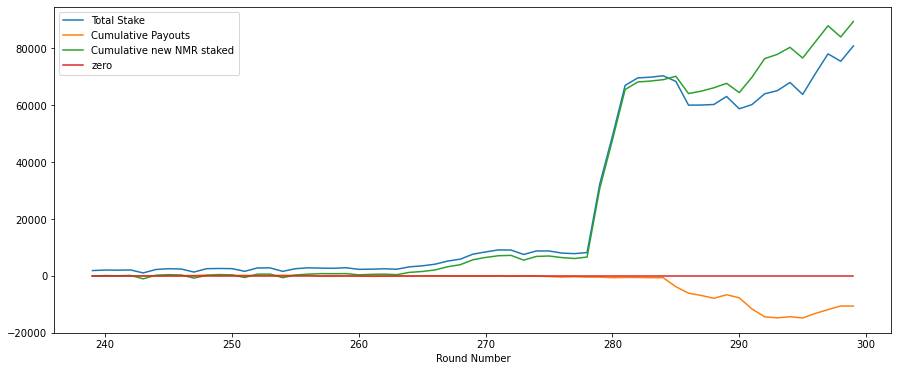

In [8]:
df['zero']=0
df.set_index('roundNumber')[['totalAtStake', 'cumPayout', 'cum_newInvestment', 'zero']].rename(columns = {'totalAtStake':'Total Stake',                                                                         
                                                                         'cumPayout': 'Cumulative Payouts',
                                                                         'cum_newInvestment':'Cumulative new NMR staked'}).plot(figsize=(15,6), xlabel='Round Number')

<AxesSubplot:xlabel='roundNumber'>

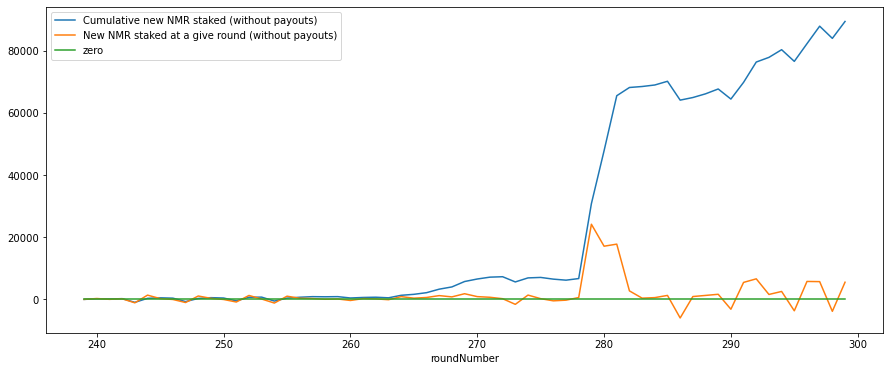

In [9]:
df.set_index('roundNumber')[['cum_newInvestment', 'newInvestment', 'zero']].rename(columns={'cum_newInvestment':'Cumulative new NMR staked (without payouts)',
                                                                   'newInvestment':'New NMR staked at a give round (without payouts)'}).plot(figsize=(15,6))

# Token supply

In [10]:
import requests
import json
url = 'https://numer.ai/nmr'
response = requests.get(url)

In [11]:
nmr =  json.loads(response.text)
circulating_supply = int(float(nmr['circulating_supply']['value']))
total_supply = int(float(nmr['total_supply']['value']))
current_stake_amount = int(float(nmr['current_stake_amount']['value']))
erasure_stake_amount = int(float(nmr['current_stake_amount_erasure']['value']))
numerai_stake_amount = current_stake_amount-erasure_stake_amount

print(f'Numerai Stake Amount: {numerai_stake_amount}')

print(f'Percentage of circulating supply at stake (all): {current_stake_amount / circulating_supply*100:0.2f}%')
print(f'Percentage of circulating supply at stake (Numerai): {numerai_stake_amount / circulating_supply*100:0.2f}%')

print(f'Percentage of circulating supply purchased for staking since r{startRound}: {sumNew/circulating_supply*100:0.2f}%')

Numerai Stake Amount: 768411
Percentage of circulating supply at stake (all): 17.66%
Percentage of circulating supply at stake (Numerai): 12.99%
Percentage of circulating supply purchased for staking since r239: 1.51%


# People at Numerai

<AxesSubplot:xlabel='roundNumber'>

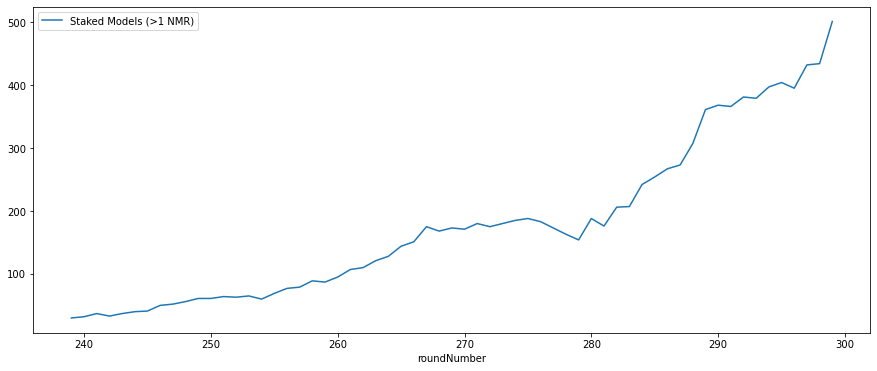

In [12]:
df.set_index('roundNumber')[['staked_model_count']].rename(columns={'staked_model_count':'Staked Models (>1 NMR)'}).plot(figsize=(15,6))